### Introduction to Stock Analysis

In this notebook you will find the basic steps to start an stock analysis:

- How to have acess to share's data
- Which share price to use and why;
- Plot a time series of your data;

Let's get rich?

In [ ]:
!pip install yfinance

In [ ]:
# inviting our friends to the party:
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, isnan, sqrt
from pylab import *
from matplotlib import style
from scipy.signal import find_peaks, savgol_filter
from datetime import date, timedelta
from pandas import Series

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

# library to import different optimizers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow import random
from tensorflow import keras

from keras.losses import BinaryCrossentropy

import yfinance as yf

%matplotlib inline

In [ ]:
# Now let's define a range, that means, from when until when we want the data:
start_date= datetime.datetime(2014, 1, 1) # the format is YYYY-MM-DD
end_date= datetime.datetime(2019, 12, 31)

In [ ]:
#start = "2014-01-01"
#end = '2019-1-01'
tsla = yf.download('TSLA',start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


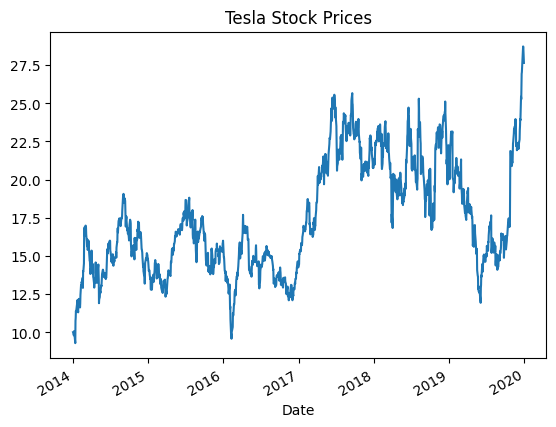

In [ ]:
tsla['Close'].plot()
plt.title("Tesla Stock Prices")
plt.show()

In [ ]:
def _get_all_indexes_above_threshold(signal, moving_average, beta):
    all_peaks = []
    all_valleys = []
    for idx, val in enumerate(signal):
        diff = val / moving_average[idx] - 1
        if diff > beta:
            all_peaks.append(idx)
        elif diff < -beta:
            all_valleys.append(idx)
    return all_peaks, all_valleys

df = tsla.copy()
df['datetime']=np.nan
df['datetime'] = df.index
df['datetime'] = df['datetime'].apply(pd.to_datetime)
df = df.set_index('datetime')
df

,Open,High,Low,Close,Adj Close,Volume
datetime,,,,,,
2014-01-02,9.986667,10.165333,9.770000,10.006667,10.006667,92826000
2014-01-03,10.000000,10.146000,9.906667,9.970667,9.970667,70425000
2014-01-06,10.000000,10.026667,9.682667,9.800000,9.800000,80416500
2014-01-07,9.841333,10.026667,9.683333,9.957333,9.957333,75511500
2014-01-08,9.923333,10.246667,9.917333,10.085333,10.085333,92448000
...,...,...,...,...,...,...
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500


In [ ]:
# A secondary method of preparing dependant data is analyzing the line simplifications of notable mins and maxes
def douglas_peucker(points, epsilon):
    """Douglas-Peucker line simplification algorithm.

    Args:
    - points: List of (x, y) tuples representing the points of the line.
    - epsilon: Tolerance parameter specifying the maximum distance allowed between the original line
               and the simplified line.

    Returns:
    - List of indices of the points that are kept in the simplified line.
    """
    # Find the point with the maximum distance
    dmax = 0
    index = 0
    end = len(points) - 1
    for i in range(1, end):
        d = perpendicular_distance(points[i], points[0], points[end])
        if d > dmax:
            index = i
            dmax = d

    # If max distance is greater than epsilon, recursively simplify both sublines
    indices = []
    if dmax > epsilon:
        indices_before = douglas_peucker(points[:index + 1], epsilon)
        indices_after = douglas_peucker(points[index:], epsilon)
        indices = indices_before[:-1] + indices_after  # Exclude the duplicate index
    else:
        # If max distance is not greater than epsilon, keep the endpoints
        indices = [points[0], points[end]]

    return indices

def perpendicular_distance(point, start, end):
    """Calculate the perpendicular distance between a point and a line segment."""
    x0, y0 = point
    x1, y1 = start
    x2, y2 = end
    numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
    return numerator / denominator

Supports and resistances are often called “key levels”.

They are price levels at which the stock price has inverted its trend. If the price rises and then inverts its trend moving down, the highest point it has reached is called resistance. If the price has gone down and then starts rising, the lowest price value is called support.

In [ ]:
# Try to find some major support and resistance values
# Not to be confused with sell or buy action points

data_high = df['High']
data_low = df['Low']
data_close = df['Close']

# Set the tolerance parameter epsilon
epsilon = 1.85  # Maximum perpendicular distance threshold
a = (np.diff(np.sign(np.diff(data_high))) < 0).nonzero()[0] + 1         # local max
points = [(i, data_high[i]) for i in range(0, df.shape[0])]
simplified_points = douglas_peucker(points, epsilon)
simplified_high_indices = [point[0] for point in simplified_points]
simplified_high_indices = [x for x in a if x in simplified_high_indices]

epsilon = 1.25  # Maximum perpendicular distance threshold
b = (np.diff(np.sign(np.diff(data_low))) > 0).nonzero()[0] + 1         # local min
points = [(i, data_low[i]) for i in range(0, df.shape[0])]
simplified_points = douglas_peucker(points, epsilon)
simplified_low_indices = [point[0] for point in simplified_points]
simplified_low_indices = [x for x in b if x in simplified_low_indices]


epsilon = 1.99  # Maximum perpendicular distance threshold
c = (np.diff(np.sign(np.diff(data_close))) != 0).nonzero()[0] + 1
points = [(i, data_close[i]) for i in range(0, df.shape[0])]
simplified_points = douglas_peucker(points, epsilon)
simplified_close_indices = [point[0] for point in simplified_points]
simplified_close_indices = [x for x in c if x in simplified_close_indices]

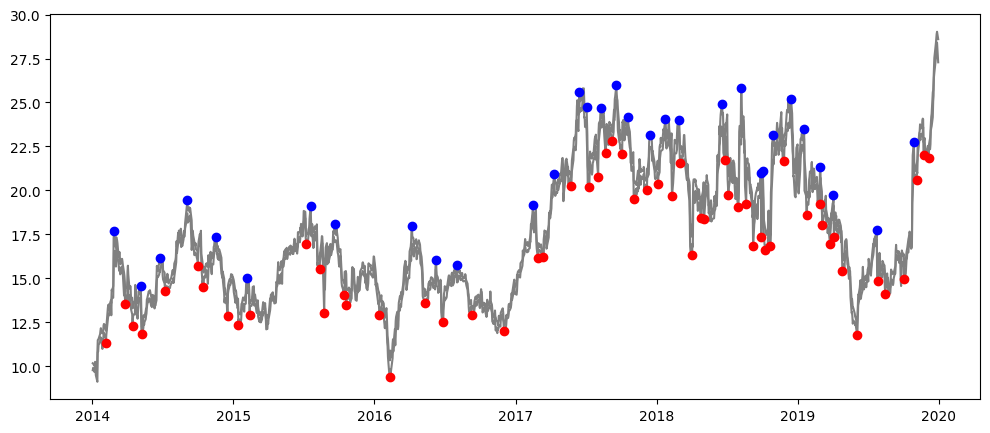

,Open,High,Low,Close,Adj Close,Volume
datetime,,,,,,
2014-02-26,17.238667,17.666668,16.500000,16.866667,16.866667,369069000
2014-05-06,14.440000,14.577333,13.790000,13.818667,13.818667,84550500
2014-06-24,15.931333,16.125334,15.442000,15.500000,15.500000,121138500
2014-09-04,18.934000,19.427999,18.693333,19.069332,19.069332,125125500
2014-11-18,17.057333,17.332666,17.034000,17.180000,17.180000,67095000
2015-02-05,14.658667,15.032000,14.642667,14.732667,14.732667,52843500
2015-07-20,18.333332,19.110001,18.169333,18.817333,18.817333,74677500
2015-09-21,17.598667,18.104668,17.053333,17.613333,17.613333,91803000
2016-04-07,17.763332,17.955999,16.967333,17.146667,17.146667,132843000


In [ ]:
plt.figure(figsize=(12, 5))
t = df.index
plt.plot(t, data_low, color='grey')
plt.plot(t, data_high, color='grey')
plt.plot(t[simplified_high_indices], data_high[simplified_high_indices], "o", label="max", color='b')
plt.plot(t[simplified_low_indices], data_low[simplified_low_indices], "o", label="min", color='r')
#plt.plot(t[simplified_close_indices], data_low[simplified_close_indices], "o", label="min", color='y')

plt.show()

df.iloc[simplified_high_indices]

## Find the cluster centroid(s) of the blue and red dots
- We want to find the major and minor stock price resistances
- We want to find the major and minor stock price support
- Note that the market makes a shift so a new set of support and resistance should also be found.

In [ ]:
two_column_df = data_high.copy().reset_index()
print(two_column_df)
#two_column_df.columns = ['Index', 'High']
two_column_df['datetime'] = two_column_df['datetime'].astype(int) // 10**9
two_column_df['datetime'] = two_column_df['datetime'] - min(two_column_df['datetime']) / 86400
#two_column_df = two_column_df.reset_index(drop=True)
#two_column_df = two_column_df.drop(columns=['Index'])
#stock_prices_standardized = two_column_df.values.reshape(-1, 1)
#stock_prices_standardized
# Select columns for K-Means
X = two_column_df[['datetime', 'High']]

# Standardize the features
scaler = StandardScaler()
stock_prices_standardized = scaler.fit_transform(X)
stock_prices_standardized

       datetime       High
0    2014-01-02  10.165333
1    2014-01-03  10.146000
2    2014-01-06  10.026667
3    2014-01-07  10.026667
4    2014-01-08  10.246667
...         ...        ...
1504 2019-12-23  28.134001
1505 2019-12-24  28.364668
1506 2019-12-26  28.898666
1507 2019-12-27  29.020666
1508 2019-12-30  28.600000

[1509 rows x 2 columns]


array([[-1.73048452, -2.02379911],
       [-1.72890192, -2.0289919 ],
       [-1.72415414, -2.06104462],
       ...,
       [ 1.72590139,  3.00794468],
       [ 1.72748399,  3.04071362],
       [ 1.73223177,  2.92772347]])

datetime
2014-01-02    10.165333
2014-01-03    10.146000
2014-01-06    10.026667
2014-01-07    10.026667
2014-01-08    10.246667
                ...    
2019-12-23    28.134001
2019-12-24    28.364668
2019-12-26    28.898666
2019-12-27    29.020666
2019-12-30    28.600000
Name: High, Length: 1509, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

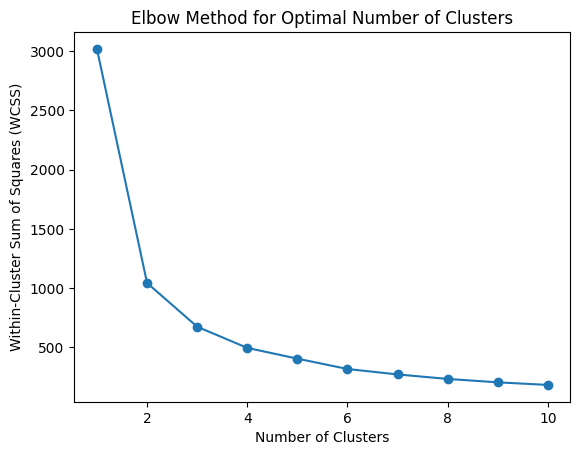

In [ ]:
# Standardize the data
print(data_high)

#stock_prices_standardized = (data_high - data_high.mean(axis=0)) / data_high.std(axis=0)
#stock_prices_standardized = data_high

# Transpose the array so that each row represents a single sample (company)
#stock_prices_standardized = two_column_df.values.reshape(-1, 1)
# Determine the optimal number of clusters using the elbow method
wcss = []
max_clusters = 10  # Maximum number of clusters to try
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(stock_prices_standardized)
    wcss.append(kmeans.inertia_)

data_high['Cluster'] = kmeans.labels_

# Plot the within-cluster sum of squares (WCSS) against the number of clusters
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Work In Progress...

A rule of thumb is that, once a resistance level is broken, it automatically becomes a support level. Viceversa, a broken support level becomes a resistance level.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<class 'pandas.core.series.Series'>


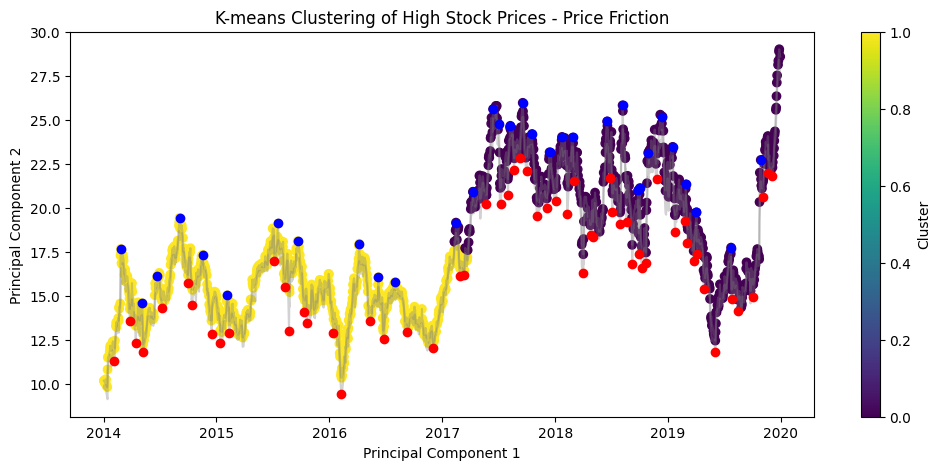

In [ ]:
# Choose the optimal number of clusters based on the elbow method (e.g., visually inspect the plot)
optimal_num_clusters = 2  # Hard coded for now, but looking for best way to programmatically determine

# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, init='k-means++', random_state=42)
kmeans.fit(stock_prices_standardized)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

plt.figure(figsize=(12, 5))
plt.plot(t, df['Low'], alpha=0.35, color='grey')
plt.plot(t, df['High'], alpha=0.35, color='grey')
plt.plot(t[simplified_high_indices], data_high[simplified_high_indices], "o", label="max", color='b')
plt.plot(t[simplified_low_indices], data_low[simplified_low_indices], "o", label="min", color='r')



# Visualize the clusters (for demonstration purposes, plot only the first two principal components)
#plt.scatter(range(0, len(stock_prices_standardized)), stock_prices_standardized[:, 0], c=cluster_labels, cmap='viridis')
X_original = scaler.inverse_transform(stock_prices_standardized)

#plt.scatter(X_original[:, 0], X_original[:, 1], c=cluster_labels, cmap='viridis')
l = len(data_high)
print(type(data_high))
data_high = data_high[data_high.index != 'Cluster']
#plt.scatter(x=range(0, len(data_high[0:l-1])), y=data_high[0:l-1], c=cluster_labels, cmap='viridis')
plt.scatter(x=data_high.index, y=data_high.values, c=cluster_labels, cmap='viridis')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering of High Stock Prices - Price Friction')
plt.colorbar(label='Cluster')



# Get cluster centroids
centroids = kmeans.cluster_centers_

# Print centroids
#print("Cluster centroids:")
#for i, centroid in enumerate(centroids):
#    print(f"Cluster {i+1}: {centroid}")
    #plt.axhline(y=centroid[2], color='r', linestyle='--')
plt.show()


In [ ]:
# Choose the optimal number of clusters based on the elbow method (e.g., visually inspect the plot)
optimal_num_clusters = 10  # Hard coded for now, but looking for best way to programmatically determine

# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, init='k-means++', random_state=1)
data_values = df.iloc[simplified_high_indices]['Close'].values
kmeans.fit(data_values.reshape(-1, 1))

# Get cluster labels for each data point
cluster_labels = kmeans.labels_
centroids = np.sort(kmeans.cluster_centers_.flatten())
print(centroids)

def split_centroids_into_difference(sorted_array, specified_value):
    # Find the index where specified_value would be inserted to maintain the sorted order
    index = np.searchsorted(sorted_array, specified_value)
    print(index, specified_value)
    # Split the sorted array into two parts based on the index
    above_specified = sorted_array[index:]-specified_value
    below_specified = specified_value - sorted_array[:index][::-1]

    return above_specified, below_specified

split_centroids_into_difference(centroids, 21)

[13.81866741 15.31699991 17.29306679 19.01816654 20.46511141 21.58633327
 22.4246664  23.37416601 24.32866669 25.44955571]
5 21


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0.58633327, 1.4246664 , 2.37416601, 3.32866669, 4.44955571]),
 array([0.53488859, 1.98183346, 3.70693321, 5.68300009, 7.18133259]))

In [ ]:
sorted_values = np.array([16, 22, 23])

# Specified threshold value
threshold_value = 20.5

# Find the index where the specified threshold value would be inserted to maintain the sorted order
insert_index = np.searchsorted(sorted_values, threshold_value)

# Values above the specified threshold value
values_above = sorted_values[insert_index:]

# Values below the specified threshold value
values_below = sorted_values[:insert_index]

# Reverse the order of values_below to match the ascending order difference from the specified value
values_below = np.flip(values_below)

# Print the arrays
print("Values above {}:".format(threshold_value), values_above)
print("Values below {}:".format(threshold_value), values_below)

Values above 20.5: [22 23]
Values below 20.5: [16]


[*********************100%%**********************]  1 of 1 completed


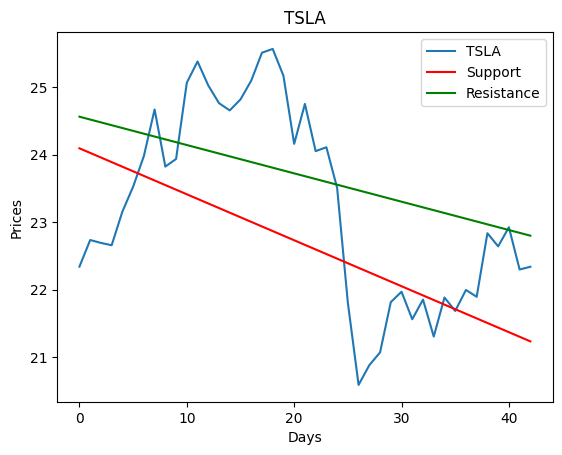

In [ ]:
def pythag(pt1, pt2):
    a_sq = (pt2[0] - pt1[0]) ** 2
    b_sq = (pt2[1] - pt1[1]) ** 2
    return sqrt(a_sq + b_sq)

def regression_ceof(pts):
    X = np.array([pt[0] for pt in pts]).reshape(-1, 1)
    y = np.array([pt[1] for pt in pts])
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0], model.intercept_

def local_min_max(pts):
    local_min = []
    local_max = []
    prev_pts = [(0, pts[0]), (1, pts[1])]
    for i in range(1, len(pts) - 1):
        append_to = ''
        if pts[i-1] > pts[i] < pts[i+1]:
            append_to = 'min'
        elif pts[i-1] < pts[i] > pts[i+1]:
            append_to = 'max'
        if append_to:
            if local_min or local_max:
                prev_distance = pythag(prev_pts[0], prev_pts[1]) * 0.5
                curr_distance = pythag(prev_pts[1], (i, pts[i]))
                if curr_distance >= prev_distance:
                    prev_pts[0] = prev_pts[1]
                    prev_pts[1] = (i, pts[i])
                    if append_to == 'min':
                        local_min.append((i, pts[i]))
                    else:
                        local_max.append((i, pts[i]))
            else:
                prev_pts[0] = prev_pts[1]
                prev_pts[1] = (i, pts[i])
                if append_to == 'min':
                    local_min.append((i, pts[i]))
                else:
                    local_max.append((i, pts[i]))
    return local_min, local_max

symbol = 'TSLA'
df_test = yf.download(symbol,'2017-05-29', '2017-07-30')
#df = web.DataReader(symbol, 'yahoo', '2019-01-01', '2019-04-01')
series = df_test['Close']
series.index = np.arange(series.shape[0])

month_diff = series.shape[0] // 30
if month_diff == 0:
    month_diff = 1

smooth = int(2 * month_diff + 3)

pts = savgol_filter(series, smooth, 3)

local_min, local_max = local_min_max(pts)

local_min_slope, local_min_int = regression_ceof(local_min)
local_max_slope, local_max_int = regression_ceof(local_max)
support = (local_min_slope * np.array(series.index)) + local_min_int
resistance = (local_max_slope * np.array(series.index)) + local_max_int

plt.title(symbol)
plt.xlabel('Days')
plt.ylabel('Prices')
plt.plot(series, label=symbol)
plt.plot(support, label='Support', c='r')
plt.plot(resistance, label='Resistance', c='g')
plt.legend()
plt.show()


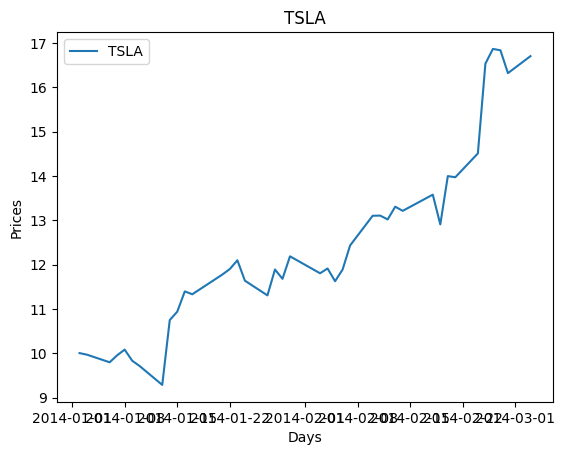

datetime
2014-01-02    10.006667
2014-01-03     9.970667
2014-01-06     9.800000
2014-01-07     9.957333
2014-01-08    10.085333
2014-01-09     9.835333
2014-01-10     9.714667
2014-01-13     9.289333
2014-01-14    10.751333
2014-01-15    10.942000
2014-01-16    11.398000
2014-01-17    11.334000
2014-01-21    11.778667
2014-01-22    11.904000
2014-01-23    12.100000
2014-01-24    11.640000
2014-01-27    11.308000
2014-01-28    11.892000
2014-01-29    11.682000
2014-01-30    12.189333
2014-01-31    12.094000
2014-02-03    11.807333
2014-02-04    11.915333
2014-02-05    11.628000
2014-02-06    11.892000
2014-02-07    12.435333
2014-02-10    13.104000
2014-02-11    13.108000
2014-02-12    13.021333
2014-02-13    13.308667
2014-02-14    13.215333
2014-02-18    13.580000
2014-02-19    12.909333
2014-02-20    13.998000
2014-02-21    13.973333
2014-02-24    14.510000
2014-02-25    16.533333
2014-02-26    16.866667
2014-02-27    16.836000
2014-02-28    16.320667
2014-03-03    16.704000
Name: C

In [ ]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def plot_me(pts):
    plt.title(symbol)
    plt.xlabel('Days')
    plt.ylabel('Prices')
    plt.plot(pts, label=symbol)
    #plt.plot(support, label='Support', c='r')
    #plt.plot(resistance, label='Resistance', c='g')
    plt.legend()
    plt.show()

# The regression window needs to have enough points to really establish a resistance or support
min_max_window = 60 # this is the regression days for support and resistance
regression_tracking_window = 10 # this is a short term regression slope indicator
regression_focus_constant = 24
d1 = datetime.timedelta(days = min_max_window)
d2 = datetime.timedelta(days = regression_tracking_window)
index = 0

df_sr = df.copy()
df_sr["60DSupport"] = np.nan
df_sr["60DResistance"] = np.nan
df_sr["10DRegression"] = np.nan

plot=True
for single_date in df_sr.index:
    if single_date >= start_date+d1:
        #df_1 = df.iloc[index]

        # look back
        df_min_max = df_sr.loc[single_date-d1:single_date]
        df_regression = df_sr.loc[single_date-d2:single_date]

        if (plot):
            plot_me(df_min_max['Close'])
            plot=False
            print(df_min_max['Close'])

        series = df_min_max['Close']
        series.index = np.arange(series.shape[0])



        month_diff = series.shape[0] // regression_focus_constant
        if month_diff == 0:
            month_diff = 1

        smooth = int(2 * month_diff + 3)

        # regression line function
        pts = savgol_filter(series, 4, 3)

        local_min, local_max = local_min_max(pts)
        # we want to break down the points into notable min points and max points

        local_regression = df_regression['Close']
        local_retression_arr = []
        for i in range(1, len(local_regression) - 1):
          local_retression_arr.append((i, local_regression[i]))

        local_min_slope, local_min_int = regression_ceof(local_min)
        local_max_slope, local_max_int = regression_ceof(local_max)
        local_regression_slope, local_int = regression_ceof(local_retression_arr)
        support = (local_min_slope * np.array(series.index)) + local_min_int
        resistance = (local_max_slope * np.array(series.index)) + local_max_int

        df_sr.loc[df_sr.index.to_pydatetime() == single_date, '60DSupport'] = local_min_slope
        df_sr.loc[df_sr.index.to_pydatetime() == single_date, '60DResistance'] = local_max_slope
        df_sr.loc[df_sr.index.to_pydatetime() == single_date, '10DRegression'] = local_regression_slope
        index = index + 1



In [ ]:
#t[simplified_low_indices]

#def nearest_datetime_index(dt, dt_list):
#    """
#    Find the nearest datetime index in dt_list that is chronologically ahead of dt.
#    """
#    return min((d for d in dt_list if d > dt), default=None)

def nearest_datetime_index(target_datetime, datetime_index):
    nearest_datetime = min(datetime_index, key=lambda x: abs(x - target_datetime))
    return nearest_datetime

# This is the success points to recognize where interesting things are happening
notable_dates = t[simplified_high_indices]

# Calculate distance for each datetime index in the second list
distances = []
df_sr['SellAction'] = 0
for dt in df_sr.index:
    nearest_dt = nearest_datetime_index(dt, notable_dates)
    if nearest_dt is not None:
        distance = abs((nearest_dt - dt).days)
        if distance <=1 :
            print("date close high point:", dt)
            df_sr['SellAction'].loc[dt] = 1

print(df_sr['SellAction'].value_counts(), len(df_sr))


date close high point: 2014-02-25 00:00:00
date close high point: 2014-02-26 00:00:00
date close high point: 2014-02-27 00:00:00
date close high point: 2014-05-05 00:00:00
date close high point: 2014-05-06 00:00:00
date close high point: 2014-05-07 00:00:00
date close high point: 2014-06-23 00:00:00
date close high point: 2014-06-24 00:00:00
date close high point: 2014-06-25 00:00:00
date close high point: 2014-09-03 00:00:00
date close high point: 2014-09-04 00:00:00
date close high point: 2014-09-05 00:00:00
date close high point: 2014-11-17 00:00:00
date close high point: 2014-11-18 00:00:00
date close high point: 2014-11-19 00:00:00
date close high point: 2015-02-04 00:00:00
date close high point: 2015-02-05 00:00:00
date close high point: 2015-02-06 00:00:00
date close high point: 2015-07-20 00:00:00
date close high point: 2015-07-21 00:00:00
date close high point: 2015-09-21 00:00:00
date close high point: 2015-09-22 00:00:00
date close high point: 2016-04-06 00:00:00
date close 

<ipython-input-14-e0bb73d78b01>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sr['SellAction'].loc[dt] = 1



date close high point: 2017-10-19 00:00:00
date close high point: 2017-12-13 00:00:00
date close high point: 2017-12-14 00:00:00
date close high point: 2017-12-15 00:00:00
date close high point: 2018-01-22 00:00:00
date close high point: 2018-01-23 00:00:00
date close high point: 2018-01-24 00:00:00
date close high point: 2018-02-26 00:00:00
date close high point: 2018-02-27 00:00:00
date close high point: 2018-02-28 00:00:00
date close high point: 2018-06-18 00:00:00
date close high point: 2018-06-19 00:00:00
date close high point: 2018-08-06 00:00:00
date close high point: 2018-08-07 00:00:00
date close high point: 2018-08-08 00:00:00
date close high point: 2018-09-26 00:00:00
date close high point: 2018-09-27 00:00:00
date close high point: 2018-09-28 00:00:00
date close high point: 2018-10-01 00:00:00
date close high point: 2018-10-02 00:00:00
date close high point: 2018-10-03 00:00:00
date close high point: 2018-10-29 00:00:00
date close high point: 2018-10-30 00:00:00
date close

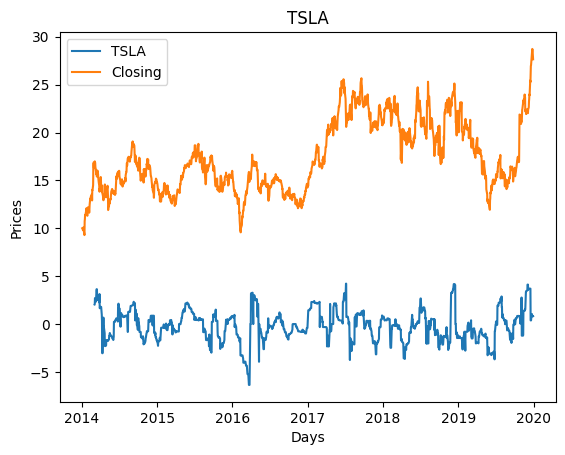

In [ ]:

plt.title(symbol)
plt.xlabel('Days')
plt.ylabel('Prices')
plt.plot(df_sr['60DSupport']*20, label=symbol)
plt.plot(df_sr['Close'], label='Closing')
plt.legend()
plt.show()

In [ ]:
# drop the first 60 rows where no independant data exists
df_framed = df_sr[min_max_window:]


# Create a new column with positive values
df_framed['60DSupportNeg'] = df_framed['60DSupport'].apply(lambda x: abs(x) if x < 0 else 0)
# Replace negative values in the original column with 0
df_framed['60DSupport'] = df_framed['60DSupport'].apply(lambda x: max(0, x))

# Create a new column with positive values
df_framed['60DResistanceNeg'] = df_framed['60DResistance'].apply(lambda x: abs(x) if x < 0 else 0)
# Replace negative values in the original column with 0
df_framed['60DResistance'] = df_framed['60DResistance'].apply(lambda x: max(0, x))

# Create a new column with positive values
df_framed['10DRegressionNeg'] = df_framed['10DRegression'].apply(lambda x: abs(x) if x < 0 else 0)
# Replace negative values in the original column with 0
df_framed['10DRegression'] = df_framed['10DRegression'].apply(lambda x: max(0, x))




X = df_framed.drop(['Open','Close', 'High', 'Low', 'Adj Close', 'Volume', 'SellAction'], axis=1)
Y = df_framed['SellAction']

df_framed.head(50)

<ipython-input-16-0c6de9f8f66a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_framed['60DSupportNeg'] = df_framed['60DSupport'].apply(lambda x: abs(x) if x < 0 else 0)
<ipython-input-16-0c6de9f8f66a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_framed['60DSupport'] = df_framed['60DSupport'].apply(lambda x: max(0, x))
<ipython-input-16-0c6de9f8f66a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,Open,High,Low,Close,Adj Close,Volume,60DSupport,60DResistance,10DRegression,SellAction,60DSupportNeg,60DResistanceNeg,10DRegressionNeg
datetime,,,,,,,,,,,,,
2014-03-31,14.433333,14.450000,13.759333,13.896667,13.896667,125700000,0.089643,0.134809,0.000000,0,0.000000,0.000000,0.191467
2014-04-01,13.934667,14.544000,13.905333,14.464667,14.464667,110571000,0.089643,0.134809,0.000000,0,0.000000,0.000000,0.163800
2014-04-02,14.666667,15.392667,14.536667,15.352667,15.352667,161734500,0.089643,0.163909,0.000000,0,0.000000,0.000000,0.049200
2014-04-03,15.353333,15.715333,14.800000,15.026667,15.026667,163855500,0.089643,0.089188,0.092143,0,0.000000,0.000000,0.000000
2014-04-04,15.067333,15.218000,14.083333,14.148667,14.148667,170184000,0.089643,0.088170,0.209191,0,0.000000,0.000000,0.000000
2014-04-07,13.720667,14.413333,13.567333,13.834667,13.834667,147832500,0.048656,0.057887,0.106600,0,0.000000,0.000000,0.000000
2014-04-08,14.003333,14.432667,13.761333,14.364000,14.364000,103339500,0.014549,0.058714,0.000000,0,0.000000,0.000000,0.246400
2014-04-09,14.450667,14.563333,14.059333,14.462000,14.462000,77368500,0.000000,0.021933,0.000000,0,0.152111,0.000000,0.169581
2014-04-10,14.454667,14.500000,13.586000,13.612667,13.612667,108172500,0.000000,0.000000,0.000000,0,0.152111,0.007757,0.113476


In [ ]:
# Display a graph to compare the training loss vs. validation loss over time
def training_history(model_history):
  # Capturing learning history per epoch
  hist = pd.DataFrame(model_history.history)
  hist['epoch'] = model_history.epoch

  # Plotting accuracy at different epochs
  plt.plot(hist['loss'])
  plt.plot(hist['val_loss'])
  plt.legend(("train" , "valid") , loc =0)

In [ ]:
#metric = 'accuracy'
#monitor = 'accuracy'
metric = keras.metrics.Recall() # True Positives/(True Positives + False Negatives)
monitor = 'recall'
#metric = keras.metrics.Precision() # True Positives/(True Positives + False Positives)
#monitor = 'precision'
#metric = keras.metrics.F1Score()
#monitor = 'f1_score'

look_back = 30


# We are responsible to fill in the look-back data
# Shift the DataFrame to create the lookback sequences
X_added = X.shift(1)  # Shift the DataFrame by 1 time step to create lag features
for i in range(2, look_back + 1):
    X_added = pd.concat([X_added, X.shift(i)], axis=1)  # Concatenate shifted DataFrame to create lookback sequences

# Drop rows with NaN values introduced by shifting
X_added.dropna(inplace=True)

# Get the target values Y
Y_added = Y.iloc[look_back:]  # Skip the first lookback rows since we don't have target values for them

# Convert DataFrame to numpy arrays
X_added = X_added.values
Y_added = Y_added.values

# train the normalization
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
scaler = scaler.fit(X_added)

# normalize the dataset and print
X_normalized = scaler.transform(X_added)


# Reshape X to match the input shape expected by LSTM
X_reshaped = X_normalized.reshape(X.shape[0]-look_back, look_back, X.shape[1])
Y_reshaped = Y_added.reshape(-1, 1)



# Define the size of the training and test sets
train_size = int(len(X_reshaped) * 0.8)  # 80% for training
test_size = len(X_reshaped) - train_size  # Remaining for test

# Ensure that the training and test sets do not include any overlapping sequences from the lookback window
train_end_index = train_size - train_size % look_back
test_start_index = train_end_index + 1

# Split the data into training and test sets
X_train, Y_train = X_reshaped[:train_end_index], Y_reshaped[:train_end_index]
X_test, Y_test = X_reshaped[test_start_index:], Y_reshaped[test_start_index:]

# Print the shapes of the training and test sets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

# df_framed contains all the raw info, but has still the extra entries the look_back clipped off
#3print(X_train.shape)
#for i in range(0,70):
#  print(i, X_train[i], df_framed.index[i+look_back], Y_train[i])

X_train shape: (1110, 30, 6)
Y_train shape: (1110, 1)
X_test shape: (308, 30, 6)
Y_test shape: (308, 1)


In [ ]:
# The LSTM network expects the input data (X) to be provided with a specific array structure
# in the form of [samples, time steps, features]. Currently, the data form is [samples, features],
# Frame the problem as one time step for each sample. Transform the prepared train and test
# input data into the expected structure using numpy.reshape() as follows:

# reshape input to be [samples, time steps, features]
#trainX = np.reshape(X_train, (X_train.shape[0]-look_back, 1, X_train.shape[1]))
#testX = np.reshape(X_test, (X_test.shape[0]-look_back, 1, X_test.shape[1]))

# reshape into X=t and Y=t+1

backend.clear_session()
model_adam = Sequential()
model_adam.add(LSTM(5, input_shape=(look_back, X.shape[1])))
model_adam.add(Dense(64, activation='relu')) # Hidden layer
model_adam.add(Dense(32, activation='relu')) # Hidden layer
model_adam.add(Dense(1, activation='sigmoid')) # Output layer


#model_adam.add(Dense(64, input_shape=(X.shape[1],),activation='relu')) # Input Layer
#model_adam.add(Dense(128, activation='relu')) # Hidden layer
#model_adam.add(Dense(64, activation='relu')) # Hidden layer
#model_adam.add(Dense(32, activation='relu')) # Hidden layer
#model_adam.add(Dense(1, activation='sigmoid')) # Output layer



model_adam.compile(loss='msle', optimizer='adam', metrics=metric)
model_history = model_adam.fit(X_train, Y_train, epochs=2, batch_size=1, verbose=2, validation_data=(X_test, Y_test))
#model_history = model_adam.fit(X, Y, epochs=7, batch_size=1, verbose=2)

Epoch 1/2
1110/1110 - 13s - loss: 0.0325 - recall: 0.0000e+00 - val_loss: 0.0270 - val_recall: 0.0000e+00 - 13s/epoch - 11ms/step
Epoch 2/2
1110/1110 - 9s - loss: 0.0243 - recall: 0.0000e+00 - val_loss: 0.0277 - val_recall: 0.0000e+00 - 9s/epoch - 8ms/step


In [ ]:
# Train the model
#training_history(model_history)
y_pr = model_adam.predict(X_test)
#print(y_pr)

#offset = X_train.shape[0]+min_max_window+look_back+1
offset = t.shape[0]-y_pr.shape[0]
index = 0
for i in y_pr:
  if i>.1:
      print(index, i, t[index+offset])
  index += 1

10/10 [==============================] - 1s 4ms/step
5 [0.10159454] 2018-10-16 00:00:00
6 [0.10568097] 2018-10-17 00:00:00
53 [0.10238045] 2018-12-26 00:00:00
54 [0.10281006] 2018-12-27 00:00:00
55 [0.11117946] 2018-12-28 00:00:00
56 [0.10465815] 2018-12-31 00:00:00
59 [0.10103627] 2019-01-04 00:00:00
60 [0.11263706] 2019-01-07 00:00:00
61 [0.13087338] 2019-01-08 00:00:00
62 [0.1545573] 2019-01-09 00:00:00
63 [0.16263887] 2019-01-10 00:00:00
64 [0.10039689] 2019-01-11 00:00:00
71 [0.10237005] 2019-01-23 00:00:00
72 [0.1031986] 2019-01-24 00:00:00
73 [0.11263753] 2019-01-25 00:00:00
74 [0.11496741] 2019-01-28 00:00:00
75 [0.12059554] 2019-01-29 00:00:00
76 [0.13006134] 2019-01-30 00:00:00
77 [0.11983911] 2019-01-31 00:00:00
78 [0.1474517] 2019-02-01 00:00:00
79 [0.12521864] 2019-02-04 00:00:00
80 [0.11356369] 2019-02-05 00:00:00
81 [0.1052582] 2019-02-06 00:00:00
82 [0.10925701] 2019-02-07 00:00:00
83 [0.10746621] 2019-02-08 00:00:00
84 [0.10949275] 2019-02-11 00:00:00
228 [0.1044658] 2

Open         1.538667e+01
High         1.570267e+01
Low          1.526267e+01
Close        1.570267e+01
Adj Close    1.570267e+01
Volume       7.325550e+07
Name: 2019-09-10 00:00:00, dtype: float64
                 Open       High        Low      Close  Adj Close     Volume
datetime                                                                    
2019-07-10  15.610000  15.929333  15.542667  15.928000  15.928000  137185500
2019-07-11  15.876000  16.100000  15.720000  15.906667  15.906667  112716000
2019-07-12  15.983333  16.358667  15.980667  16.338667  16.338667  138007500
2019-07-15  16.533333  16.961332  16.323999  16.900000  16.900000  165001500
2019-07-16  16.620001  16.902000  16.528667  16.825333  16.825333  122235000
...               ...        ...        ...        ...        ...        ...
2019-12-23  27.452000  28.134001  27.333332  27.948000  27.948000  199794000
2019-12-24  27.890667  28.364668  27.512667  28.350000  28.350000  120820500
2019-12-26  28.527332  28.898666

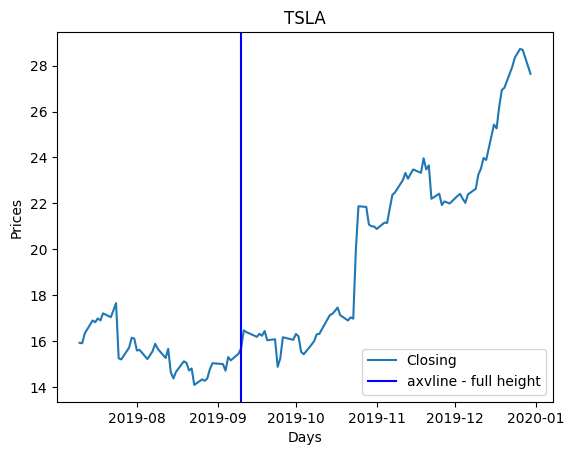

In [ ]:

#df_sr.index.to_pydatetime()
datetime_index_pre = pd.to_datetime('2019-07-10')
datetime_index = pd.to_datetime('2019-09-10')
single_row = df.loc[datetime_index]
print(single_row)

# Assuming df is your DataFrame indexed by datetime
# datetime_index is the datetime you want to retrieve
datetime_index_post = pd.to_datetime('2019-12-30')
single_row = df.loc[datetime_index_pre:datetime_index_post]
print(single_row)

plt.title(symbol)
plt.xlabel('Days')
plt.ylabel('Prices')
plt.plot(single_row['Close'], label='Closing')
# only one line may be specified; full height
plt.axvline(x=datetime_index, color='b', label='axvline - full height')
plt.legend()
plt.show()